# Fit di segnale in presenza di rumore

Molto spesso ci si trova nella situazione di dover determinare la quantit\`a di segnale presente in uno spettro misurato, sapendo di aver osservato un sistema fisico che produce eventi di interesse (segnale) contaminati da impulsi spuri (il fondo).


 * Si scriva una libreria di Python che contenga l'implementazione di una distribuzione di densit\`a di probabilit\`a, chiamata \verb!pdf_fondo!, definita su un intervallo $[0,M]$. La funzione avrà la forma di $A \times \sin (Bx)$, dove i due parametri $A$ e $B$ sono determinati dalle richieste che sull'intervallo di definizione la funzione formi mezzo periodo e che sia normalizzata. Si scriva la funzione in modo che, oltre alla variabile $x$, prenda in ingresso tutti i parametri necessari a definirla.
 * Si faccia il disegno della funzione sull'intervallo di definizione e si controlli che la funzione è normalizzata, utilizzando il metodo *hit-or-miss* di integrazione.

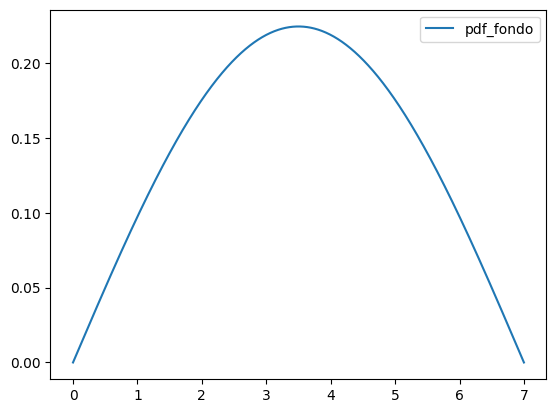

In [1]:
from lib import pdf_fondo, cdf_fondo, generate_range, inverse, sturges, generate_TAC, gauss
import matplotlib.pyplot as plt
import numpy as np
import random

M = 7.

fig, ax = plt.subplots (nrows = 1, ncols = 1)
x_axis = np.linspace (0., M, 1000)
func = lambda x : pdf_fondo (x, M)
ax.plot (x_axis, func (x_axis), label = 'pdf_fondo')
ax.legend ()
plt.show ()

In [2]:
from lib import integral_HOM

integral = integral_HOM (func, 0., M, func (M/2), 10000)

print ('the resulting integral is:', integral[0] , '+-', np.sqrt (integral[1]))

the resulting integral is: 1.0051525695160544 +- 0.007540280340010865



 * si generi un campione di 1000 punti pseudo-casuali distribuiti secondo \verb!pdf_fondo! utilizzando il metodo della funzione inversa e se ne disegni l'istogramma, scegliendone con un algoritmo opportuno il binnaggio.

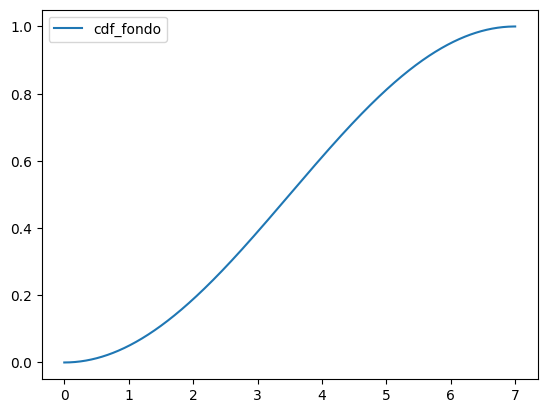

In [3]:
fig, ax = plt.subplots (nrows = 1, ncols = 1)
func_2 = lambda x : cdf_fondo (x, M)
ax.plot (x_axis, func_2 (x_axis), label = 'cdf_fondo')
ax.legend ()
plt.show ()

(array([ 3., 10., 17., 15., 28., 42., 44., 36., 40., 53., 55., 56., 68.,
        70., 76., 93., 76., 77., 95., 84., 88., 84., 69., 85., 75., 79.,
        69., 73., 65., 62., 48., 46., 32., 25., 30., 19., 11.,  2.]),
 array([0.        , 0.18421053, 0.36842105, 0.55263158, 0.73684211,
        0.92105263, 1.10526316, 1.28947368, 1.47368421, 1.65789474,
        1.84210526, 2.02631579, 2.21052632, 2.39473684, 2.57894737,
        2.76315789, 2.94736842, 3.13157895, 3.31578947, 3.5       ,
        3.68421053, 3.86842105, 4.05263158, 4.23684211, 4.42105263,
        4.60526316, 4.78947368, 4.97368421, 5.15789474, 5.34210526,
        5.52631579, 5.71052632, 5.89473684, 6.07894737, 6.26315789,
        6.44736842, 6.63157895, 6.81578947, 7.        ]),
 <BarContainer object of 38 artists>)

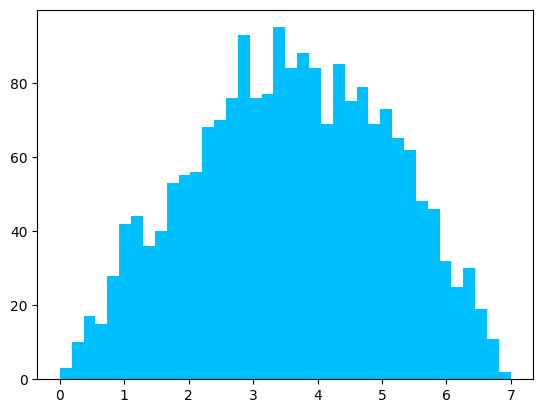

In [4]:
N_evt = 2000

sample_bkg = [inverse (random.random (), M) for x in range (N_evt)]

h_min = np.floor (min (sample_bkg))
h_max = np.ceil (max (sample_bkg))
n_bins = sturges (len (sample_bkg))

bin_content, bin_edges = np.histogram (sample_bkg, bins = n_bins, range = (h_min, h_max))

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.hist (sample_bkg,
         bins = bin_edges,
         color = 'deepskyblue',
        )



 * Si generi, utilizzando il metodo \textit{try-and-catch}, un secondo campione di 1000 eventi secondo una distribuzione Gaussiana con media $M/4$ e larghezza $M/16$, lo si unisca a quello generato precedentemente.

(array([  2.,  10.,  15.,  18.,  34.,  56.,  75., 142., 177., 221., 268.,
        211., 138., 105.,  80.,  74.,  92.,  76.,  71.,  89.,  80.,  85.,
         78.,  68.,  82.,  69.,  74.,  73.,  64.,  64.,  59.,  54.,  49.,
         39.,  25.,  28.,  29.,  14.,  10.,   2.]),
 array([0.   , 0.175, 0.35 , 0.525, 0.7  , 0.875, 1.05 , 1.225, 1.4  ,
        1.575, 1.75 , 1.925, 2.1  , 2.275, 2.45 , 2.625, 2.8  , 2.975,
        3.15 , 3.325, 3.5  , 3.675, 3.85 , 4.025, 4.2  , 4.375, 4.55 ,
        4.725, 4.9  , 5.075, 5.25 , 5.425, 5.6  , 5.775, 5.95 , 6.125,
        6.3  , 6.475, 6.65 , 6.825, 7.   ]),
 <BarContainer object of 40 artists>)

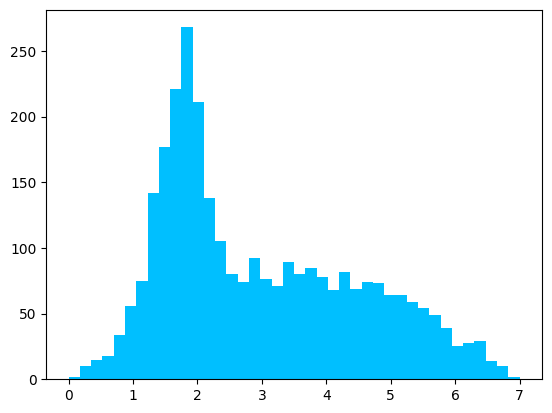

In [5]:
func_3 = lambda x : gauss (x, M/4, M/20)
sample_sig = generate_TAC (func_3, 0., M/2, func_3 (M/4), 1000)

sample_tot = sample_bkg + sample_sig

h_min = 0
h_max = M
n_bins = sturges (len (sample_tot))

bin_content, bin_edges = np.histogram (sample_tot, bins = n_bins, range = (h_min, h_max))

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.hist (sample_tot,
         bins = bin_edges,
         color = 'deepskyblue',
        )



 *  Si determini quale sia il bias medio dello stimatore $\hat{\mu}$ che determina la posizione del massimo del segnale con un fit Gaussiano fra $0$ e $M/2$.

In [6]:
# singolo fit di prova

from iminuit import Minuit
from scipy.stats import norm
from iminuit.cost import BinnedNLL

sample_selected = [x for x in sample_tot if x < M/2.]
n_bins = sturges (len (sample_selected))
bin_content, bin_edges = np.histogram (sample_selected, bins = n_bins, range = (h_min, h_max))

# the fitting function
def mod_total (bin_edges, mu, sigma):
    return norm.cdf (bin_edges, mu, sigma)
    
# N_events = sum (bin_content)

# the cost function for the fit
my_cost_func = BinnedNLL (bin_content, bin_edges, mod_total)

sample_mean  = np.mean (sample_selected)
sample_sigma = np.std (sample_selected)

# the fitting algoritm
my_minuit = Minuit (my_cost_func, mu = sample_mean, sigma = sample_sigma)
my_minuit.migrad ()

display (my_minuit)                       

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 349.8 (χ²/ndof = 9.7)      │              Nfcn = 24               │
│ EDM = 6.72e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   1.997   │   0.016   │            │            │         │         │       │
│ 1 │ sigma │   0.694   │   0.011   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000248        0 │
│ sigma │        0 0.000125 │
└───────┴───────────────────┘

In [7]:
# ripetizione di tanti fit per ottenere il bias medio

N_toys = 1000
means = []

for i in range (N_toys):
    sample_bkg = [inverse (random.random (), M) for x in range (N_evt)]
    sample_sig = generate_TAC (func_3, 0., M/2, func_3 (M/4), 1000)
    sample_tot = sample_sig + sample_bkg
    sample_selected = [x for x in sample_tot if x < M/2.]
    n_bins = sturges (len (sample_selected))
    bin_content, bin_edges = np.histogram (sample_selected, bins = n_bins, range = (h_min, h_max))
    sample_mean  = np.mean (sample_selected)
    sample_sigma = np.std (sample_selected)
    
    # the fitting algoritm
    my_cost_func = BinnedNLL (bin_content, bin_edges, mod_total)
    my_minuit = Minuit (my_cost_func, mu = sample_mean, sigma = sample_sigma)
    my_minuit.migrad ()

    if not my_minuit.valid: continue
    means.append (my_minuit.values[0])

expected mean bias: 0.23786918871986584
expected bias standard deviation: 0.014538769314893514


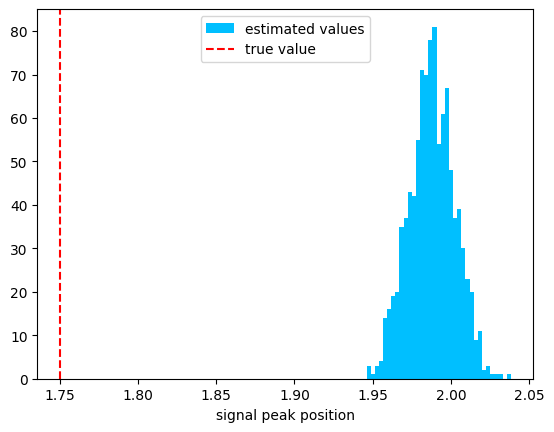

In [8]:
print ('expected mean bias:', np.mean (means) - M/4.)
print ('expected bias standard deviation:', np.std (means))

h_min = min (means) 
h_max = max (means)
n_bins = sturges (len (means))

bin_content, bin_edges = np.histogram (means, bins = n_bins, range = (h_min, h_max))

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.hist (means,
         bins = bin_edges,
         color = 'deepskyblue',
         label = 'estimated values',
        )
ax.axvline (x=M/4., color='red', linestyle='--', label='true value')
ax.set_xlabel ('signal peak position')
ax.legend ()
